# Results for SImulation Data

In [1]:
import os
os.chdir("..")

In [2]:
import random
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from training.vit_unet import load_model as load_vit_unet
from training.unet import load_model as load_unet
from training.diffusion import load_model as load_diffusion

from dataloader.simulation import data_stat
from dataloader.simulation import create_dataset

from inference.metrics import EvaluationMetricsSim, DiffusionEvaluation


# Error Visualisation comparision 

In [3]:
# Load models
img_size = (75,110)

vit_unet_model = load_vit_unet(img_size, load_checkpoint=True)
unet_model = load_unet(img_size, load_checkpoint=True)
diffusion_model = load_diffusion(img_size, load_checkpoint=True)

Loading existing model from :  model_weights/vit.pth
Loading existing model from :  model_weights/unet.pth
Loading existing model from :  model_weights/diffusion.pth


In [4]:
_, val_dataset_polair_discrim = create_dataset(normalisation=False, train_idx=7000)
_, val_dataset_polair_generative = create_dataset(normalisation=True, train_idx=7000)

In [5]:
# Select random points from validation set for generative model

random.seed(42)  # Fix the seed
random_list = [random.randint(0, len(val_dataset_polair_generative)-1) for _ in range(8)]  # Example: 10 numbers
print(random_list)

org_img, mask, vt = val_dataset_polair_generative[random_list[0]]

org_img = org_img.unsqueeze(0)
mask = mask.unsqueeze(0)
vt = vt.unsqueeze(0)

for i in range(1,8):
    a,c,b = val_dataset_polair_generative[random_list[i]]
    a = a.unsqueeze(0)
    c = c.unsqueeze(0)
    b = b.unsqueeze(0)
    org_img = torch.concat((org_img,a), dim=0)
    mask = torch.concat((mask,c), dim=0)
    vt = torch.concat((vt,b), dim=0)

predicted_images_diffusion = diffusion_model.ensemble_prediction(org_img, mask, vt, num_inf_steps=10, num_ensem_steps=20, device='cuda')[-1]

predicted_images_diffusion = predicted_images_diffusion.cpu()

[1309, 228, 51, 563, 501, 457, 285, 1508]


In [6]:
# Select random points from validation set for discriminative model

random.seed(42)  # Fix the seed
random_list = [random.randint(0, len(val_dataset_polair_discrim)-1) for _ in range(8)]  # Example: 10 numbers
print(random_list)

org_img, _, vt = val_dataset_polair_discrim[random_list[0]]

org_img = org_img.unsqueeze(0)
vt = vt.unsqueeze(0)

for i in range(1,8):
    a,_,b = val_dataset_polair_discrim[random_list[i]]
    a = a.unsqueeze(0)
    b = b.unsqueeze(0)
    org_img = torch.concat((org_img,a), dim=0)
    vt = torch.concat((vt,b), dim=0)

predicted_images_vit = vit_unet_model.call_model(vt).cpu()
predicted_images_unet = unet_model.call_model(vt).cpu()

org_img = org_img.cpu()
vt = vt.cpu()

[1309, 228, 51, 563, 501, 457, 285, 1508]


In [7]:
# Create plot

def plot_result(truth, obs_input, pred_vit, pred_unet, pred_diff, data_type, dict_minmax, dict_meanstd):
    f, ax = plt.subplots(8, 5, figsize=(14, 16))
    data_min = dict_minmax[data_type][0]
    data_max = dict_minmax[data_type][1]
    data_mean = dict_meanstd[data_type][0]
    data_std = dict_meanstd[data_type][1]
    title = ['obs_input', 'truth', 'out(ViT+UNet)', 'error(ViT+UNet)', 'out(UNet)', 'error(UNet)', 'out(diffusion)', 'error(diffusion)']
    for i in range(5):
        plot_truth = truth[i]*(data_max-data_min) + data_min
        plot_obs_input = obs_input[i]*(data_max-data_min) + data_min
        plot_prediction1 = pred_vit[i]*(data_max-data_min) + data_min
        plot_prediction2 = pred_unet[i]*(data_max-data_min) + data_min
        plot_prediction3 = pred_diff[i]*data_std/0.5 + data_mean
        
        plot_error1 = torch.abs(plot_truth - plot_prediction1.cpu())
        plot_error2 = torch.abs(plot_truth - plot_prediction2.cpu())
        plot_error3 = torch.abs(plot_truth - plot_prediction3.cpu())

        err_max = torch.max(torch.concat((plot_error1, plot_error2, plot_error3)))

        im = [
            ax[0,i].imshow(plot_obs_input, vmin=0, vmax=torch.max(plot_truth)),
            ax[1,i].imshow(plot_truth, vmin=0, vmax=torch.max(plot_truth)),
            ax[2,i].imshow(plot_prediction1, vmin=0, vmax=torch.max(plot_truth)),
            ax[3,i].imshow(plot_error1, cmap='jet', vmin=0, vmax=err_max),
            ax[4,i].imshow(plot_prediction2, vmin=0, vmax=torch.max(plot_truth)),
            ax[5,i].imshow(plot_error2, cmap='jet', vmin=0, vmax=err_max),
            ax[6,i].imshow(plot_prediction3, vmin=0, vmax=torch.max(plot_truth)),
            ax[7,i].imshow(plot_error3, cmap='jet', vmin=0, vmax=err_max)
            ]
        for j in range(8):
            ax[j,i].axis('off')
            ax[j,i].set_title(title[j])
            cbar = f.colorbar(im[j], ax=ax[j,i])

    plt.tight_layout()   
    plt.savefig('result/simulation_data/visualise/' + str(data_type) + '.svg')     

In [ ]:
dict_minmax, dict_meanstd = data_stat()

for data_type in range(4):
    plot_result(org_img[:,data_type,:,:], vt[:,data_type,:,:], predicted_images_vit[:,data_type,:,:], predicted_images_unet[:,data_type,:,:],
             predicted_images_diffusion[:,data_type,:,:], data_type, dict_minmax, dict_meanstd)

# Evaluation Metrics

SSIM Measure and Relative Error for Discriminative Model

In [3]:
# Load models
img_size = (75,110)

vit_unet_model = load_vit_unet(img_size, load_checkpoint=True)
unet_model = load_unet(img_size, load_checkpoint=True)
diffusion_model = load_diffusion(img_size, load_checkpoint=True)

# Load dataset
_, val_dataset_polair_discrim = create_dataset(normalisation=False, train_idx=7000)
_, val_dataset_polair_generative = create_dataset(normalisation=True, train_idx=7000)

val_dataloader_discrim = DataLoader(val_dataset_polair_discrim, batch_size=32, shuffle=False)
val_dataloader_generative = DataLoader(val_dataset_polair_generative, batch_size=32, shuffle=False)

Loading existing model from :  model_weights/vit.pth
Loading existing model from :  model_weights/unet.pth
Loading existing model from :  model_weights/diffusion.pth


In [4]:
dict_minmax, dict_meanstd = data_stat()
eval_metric = EvaluationMetricsSim(dict_minmax)

vit_path = eval_metric.evaluate_model(vit_unet_model, val_dataloader_discrim, 'vit_unet')   # Save metrics for Vit+Unet model
unet_path = eval_metric.evaluate_model(unet_model, val_dataloader_discrim, 'unet')   # Save metrics for Unet model

JSON file created successfully!
JSON file created successfully!


SSIM Measure and Relative Error for Generative model

In [ ]:
eval_metric_diff = DiffusionEvaluation(dict_meanstd)

# Create SSIM Measure and Rel error for various inference step size and ensemble size
inf_steps = [2,5,8,10,15,20,25,30,40,50]
diffusion_path = eval_metric_diff.create_ensem_inf_metrics(val_dataset_polair_generative, diffusion_model, ensem_size=20, inf_steps_size=inf_steps)

In [6]:
# Load the relative error
diffusion_path = 'result/simulation_data/relative_error/numpy_files/relative_error_diffusion.npy'

vit_rel_error = np.load(vit_path)
unet_rel_error = np.load(unet_path)
diffusion_rel_error = np.load(diffusion_path)

Plot Relative Error Histogram

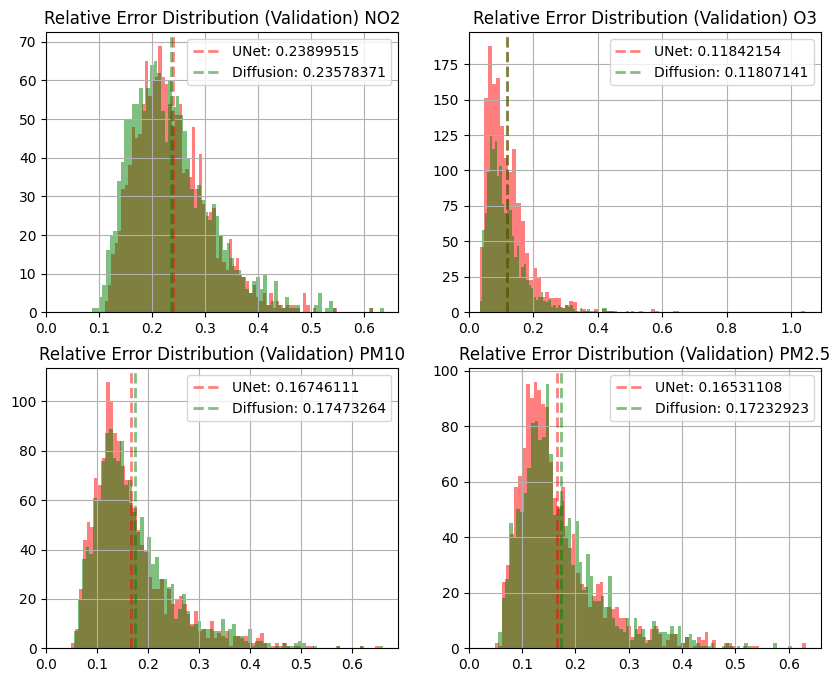

In [7]:
f, ax = plt.subplots(2, 2, figsize=(10,8))
c=0
title = ['NO2', 'O3', 'PM10', 'PM2.5']
for i in range(2):
    for j in range(2):
        
        #ax[i,j].hist(vit_rel_error[:,c], bins=80, color='blue', alpha=0.5)
        ax[i,j].hist(unet_rel_error[:,c], bins=80, color='red', alpha=0.5)
        ax[i,j].hist(diffusion_rel_error[:,c], bins=80, color='green', alpha=0.5)

        #ax[i,j].axvline(x=vit_rel_error[:,c].mean(), color='blue', linestyle='--', linewidth=2, alpha=0.5, label='ViT+UNet: '+ str(vit_rel_error[:,c].mean()))
        ax[i,j].axvline(x=unet_rel_error[:,c].mean(), color='red', linestyle='--', linewidth=2, alpha=0.5, label='UNet: '+ str(unet_rel_error[:,c].mean()))
        ax[i,j].axvline(x=diffusion_rel_error[:,c].mean(), color='green', linestyle='--', linewidth=2, alpha=0.5, label='Diffusion: '+ str(diffusion_rel_error[:,c].mean()))
        
        ax[i,j].grid()
        ax[i,j].legend()
        ax[i,j].set_xlim(left=0)
        ax[i,j].set_title('Relative Error Distribution (Validation) ' + title[c])
        c+=1

plt.savefig('result/simulation_data/relative_error/relative_error_unet_diff.png')

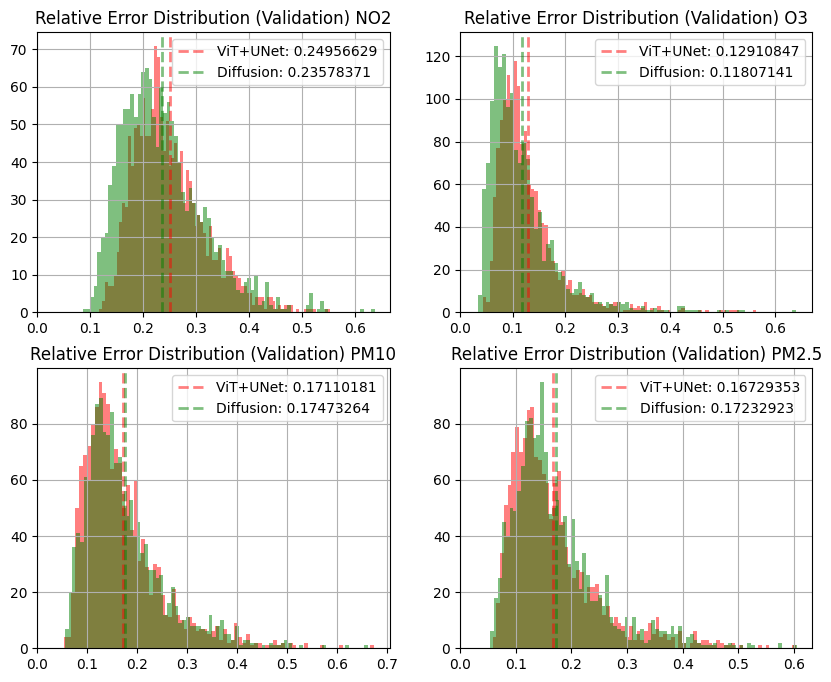

In [8]:
f, ax = plt.subplots(2, 2, figsize=(10,8))
c=0
title = ['NO2', 'O3', 'PM10', 'PM2.5']
for i in range(2):
    for j in range(2):
        
        ax[i,j].hist(vit_rel_error[:,c], bins=80, color='red', alpha=0.5)
        #ax[i,j].hist(unet_rel_error[:,c], bins=80, color='red', alpha=0.5)
        ax[i,j].hist(diffusion_rel_error[:,c], bins=80, color='green', alpha=0.5)

        ax[i,j].axvline(x=vit_rel_error[:,c].mean(), color='red', linestyle='--', linewidth=2, alpha=0.5, label='ViT+UNet: '+ str(vit_rel_error[:,c].mean()))
        #ax[i,j].axvline(x=unet_rel_error[:,c].mean(), color='red', linestyle='--', linewidth=2, alpha=0.5, label='UNet: '+ str(unet_rel_error[:,c].mean()))
        ax[i,j].axvline(x=diffusion_rel_error[:,c].mean(), color='green', linestyle='--', linewidth=2, alpha=0.5, label='Diffusion: '+ str(diffusion_rel_error[:,c].mean()))
        
        ax[i,j].grid()
        ax[i,j].legend()
        ax[i,j].set_xlim(left=0)
        ax[i,j].set_title('Relative Error Distribution (Validation) ' + title[c])
        c+=1

plt.savefig('result/simulation_data/relative_error/relative_error_vit_diff.png')

Plot Mean Relative Error and SSIM measure vs Ensemble Size for various Inference steps for Diffusion Model

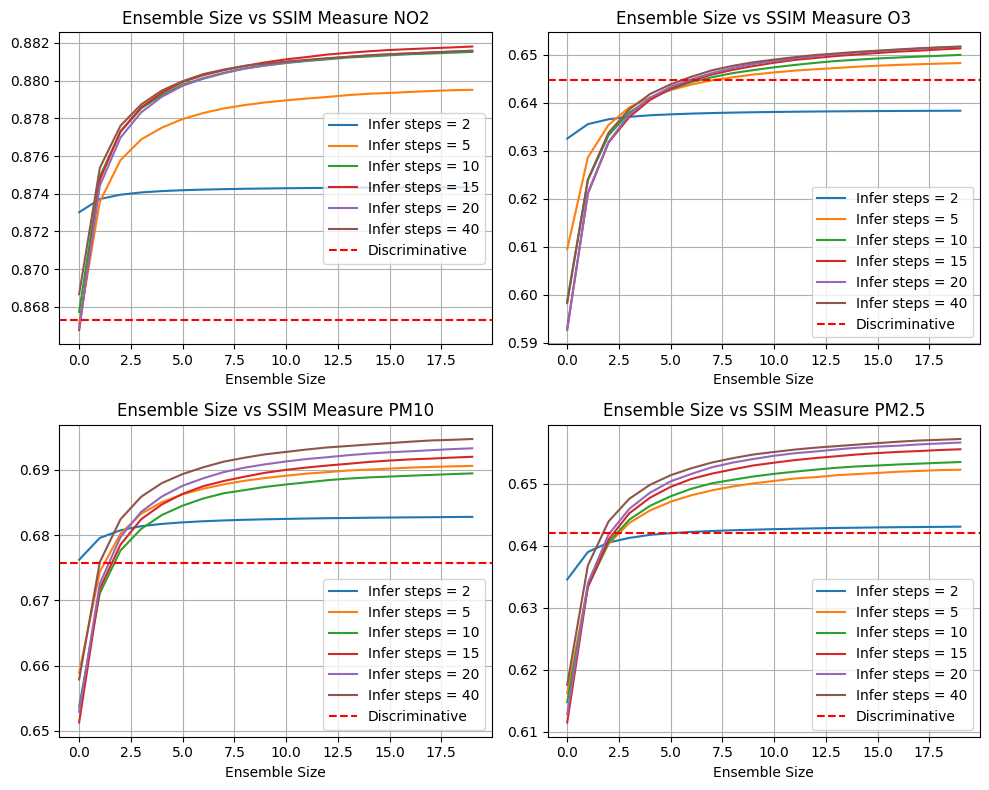

In [9]:
with open('result/simulation_data/output_metric_unet.json', 'r') as file:
    # Load the JSON data into a Python dictionary
    data = json.load(file)

unet_ssim = data['SSIM']
unet_mean_err = data['Relative error']

inf_steps_list = [2,5,10,15,20,40]

f, ax = plt.subplots(2, 2, figsize=(10,8))
c=0
title = ['NO2', 'O3', 'PM10', 'PM2.5']
for k in range(len(inf_steps_list)):
    c=0
    with open('result/simulation_data/diffusion_metrics/output_metric_inf_size_'+ str(inf_steps_list[k]) + '.json', 'r') as file:
        data = json.load(file)
        
    ssim_meas = np.array(data['SSIM'])

    for i in range(2):
        for j in range(2):    
            ax[i,j].plot(ssim_meas[:,c], label='Infer steps = ' + str(inf_steps_list[k]))
            ax[i,j].grid()
            ax[i,j].set_title('Ensemble Size vs SSIM Measure ' + title[c])
            ax[i,j].set_xlabel('Ensemble Size')
            ax[i,j].legend()
            c+=1

ax[0,0].axhline(unet_ssim['0'], linestyle='--', label='Discriminative', color='red')
ax[0,1].axhline(unet_ssim['1'], linestyle='--', label='Discriminative', color='red')
ax[1,0].axhline(unet_ssim['2'], linestyle='--', label='Discriminative', color='red')
ax[1,1].axhline(unet_ssim['3'], linestyle='--', label='Discriminative', color='red')
for i in range(2):
    for j in range(2): 
        ax[i,j].legend()
        ax[i,j].grid()

plt.tight_layout()

plt.savefig('result/simulation_data/diffusion_metrics/ssim_ensem_inf.svg')

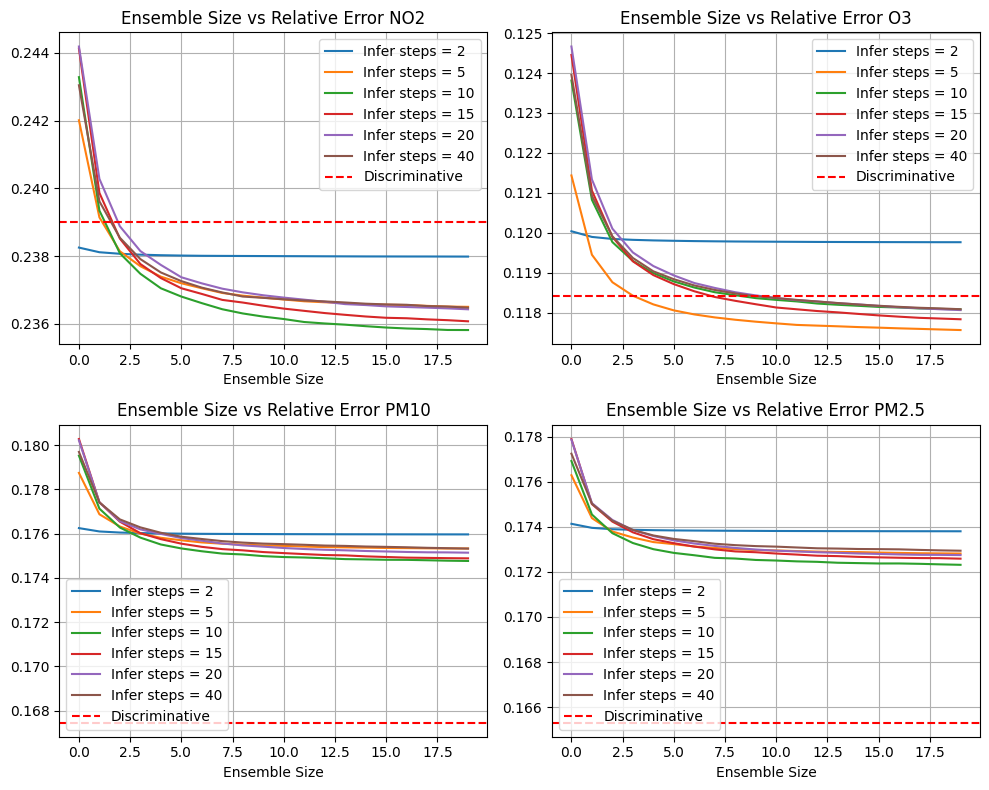

In [11]:
inf_steps_list = [2,5,10,15,20,40]

f, ax = plt.subplots(2, 2, figsize=(10,8))
c=0
title = ['NO2', 'O3', 'PM10', 'PM2.5']
for k in range(len(inf_steps_list)):
    c=0
    with open('result/simulation_data/diffusion_metrics/output_metric_inf_size_'+ str(inf_steps_list[k]) + '.json', 'r') as file:
        data = json.load(file)

    relative_error = data['Relative error']
    relative_error_list = []
    for i in range(len(relative_error)):
        relative_error_list.append(relative_error[str(i)])

    relative_error_list = np.array(relative_error_list)

    for i in range(2):
        for j in range(2):    
            ax[i,j].plot(relative_error_list[:,c], label='Infer steps = ' + str(inf_steps_list[k]))
            ax[i,j].grid()
            ax[i,j].set_title('Ensemble Size vs Relative Error ' + title[c])
            ax[i,j].set_xlabel('Ensemble Size')
            ax[i,j].legend()
            c+=1

ax[0,0].axhline(unet_mean_err[0], linestyle='--', label='Discriminative', color='red')
ax[0,1].axhline(unet_mean_err[1], linestyle='--', label='Discriminative', color='red')
ax[1,0].axhline(unet_mean_err[2], linestyle='--', label='Discriminative', color='red')
ax[1,1].axhline(unet_mean_err[3], linestyle='--', label='Discriminative', color='red')
for i in range(2):
    for j in range(2): 
        ax[i,j].legend()
        ax[i,j].grid()

plt.tight_layout()

plt.savefig('result/simulation_data/diffusion_metrics/relerr_ensem_inf.svg')